用于测试 class  

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import factorial 
from scipy.signal import convolve2d

import astropy.units as u
from astropy.table import Table

# 参数类  
现在，按照以下规则对模型的所有参数进行分类：  

* 可变参数:  
    在 fit 时，可能发生变化的参数。值得注意的是，当你在 fit 时，你可以冻结任意可变参数，从而让他们不会变化。  
* 不可变参数：  
    在 fit 时，不发生变化的参数。  
    
所有的可变参数由`Parameters`类统一管理，单个可变参数是`parameter`的实例。

In [246]:
class Parameter:
    '''
    Base class for parameter.
    '''
    
    def __init__(self,name,value,unit='',frozen=False):
        self.name=name
        self.value=value
        self.unit=u.Unit(unit)
        self.frozen=frozen

    def __str__(self):
        ss = f'{self.__class__.__name__}\n'
        
        ss+='\t{:^12} {:^12} {:^16} {:^12}\n'.format('name','value','unit','frozen')
        
        separator='-'*8
        ss+='\t{:-^12} {:-^12} {:-^16} {:-^12}\n'.format(separator,separator,separator,separator)
        ss+='\t{:>12} {:>12.2f} {:>16} {:>12}\n'.format(self.name,self.value,self.unit,str(self.frozen))
        
        return ss
    
    def __repr__(self):
        return (
            f"{self.__class__.__name__}(name={self.name!r},\tvalue={self.value!r},\t"
            f"unit={self.unit!r},\tfrozen={self.frozen!r}) "
        )
    
    @property
    def quantity(self):
        return self.value*self.unit
    
    @quantity.setter
    def quantity(self,val):
        val=u.Quantity(val,unit=self.unit)
        self.value=val.value
        self.unit=val.unit

    
class Parameters:
    '''
    List of `parameter`.
    '''
    
    def __init__(self,parameters=None):
        if parameters is None:
            parameters = []
        
        else:
            self.parameters = parameters
        
    def __add__(self,other):
        return Parameters(self.parameters+other.parameters)
    
    def _get_idx(self,key):
        if isinstance(key,int):
            return key
        elif isinstance(key,str):
            for idx,p in enumerate(self.parameters):
                if key==p.name:
                    return idx
        elif isinstance(key,Parameter):
            return self.parameters.index(key)
    
    def __getitem__(self,key):
        idx=self._get_idx(key)
        return self.parameters[idx]
    
    def __setitem__(self,key,value):
        idx=self._get_idx(key)
        self.parameters[idx].quantity=value
    
    def __str__(self):
        ss = f'{self.__class__.__name__}\n'
        
        ss+='\t{:^12} {:^12} {:^16} {:^12}\n'.format('name','value','unit','frozen')
        separator='-'*8
        ss+='\t{:-^12} {:-^12} {:-^16} {:-^12}\n'.format(separator,separator,separator,separator)
        
        for p in self.parameters:
            ss+='\t{:>12} {:>12.2e} {:>16} {:>12}\n'.format(p.name,p.value,p.unit,str(p.frozen))
        return ss
        
    def __repr__(self):
        ss = f'{self.__class__.__name__}[\n'
        for p in self.parameters:
            ss+=f"(name={p.name!r},\tvalue={p.value!r},\tunit={p.unit!r},\tfrozen={p.frozen!r})\n"
        ss+=']'
        return ss
        
    @property
    def names(self):
        return [p.name for p in self.parameters]
    
    @property
    def values(self):
        return [p.value for p in self.parameters]
    
    @property
    def units(self):
        return [p.unit for p in self.parameters]
    
    @property
    def quantitys(self):
        return [p.quantity for p in self.parameters]
    
    @property
    def frozens(self):
        return [p.frozen for p in self.parameters]
    
    @property
    def free_parameters(self):
        return [p for p in self.parameters if not p.frozen]
    
    @property
    def free_values(self):
        return [p.value for p in self.parameters if not p.frozen]
        
    @property
    def free_names(self):
        return [p.name for p in self.parameters if not p.frozen]
    
    def set_parameters(self,keys,values):
        if isinstance(keys,list):
            for key,value in zip(keys,values):
                idx=self._get_idx(key)
                self.parameters[idx].quantity=value
        
        else:
            idx=self._get_idx(keys)
            self.parameters[idx].quantity=values
    
    def to_table(self):
        t = Table()
        t['name']=self.names
        t['value']=self.values
        t['unit']=self.units
        t['frozen']=self.frozens
        return t

Parameter 类的实例以及修改：  

In [247]:
para1=Parameter('A',3,u.Unit("cm-2 s-1 GeV-1"))
print(para1)

para1.quantity=2
print(para1)

Parameter
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	           A         3.00  1 / (cm2 GeV s)        False

Parameter
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	           A         2.00  1 / (cm2 GeV s)        False



Parameters 的实例

In [245]:
para2=Parameter('B',2,u.Unit("m2"))
para3=Parameter('C',0.1,u.Unit('deg'))

paras1=Parameters([para1,para2])
print(paras1,'\n')
print('names:\t',paras1.names)
print('units:\t',paras1.units)

# Merge two `Parameters` into one.
print('\nMerge two `Parameters` into one:')
paras2=Parameters([para3])
paras3=paras1+paras2
print(paras3)

Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	           A     2.00e+00  1 / (cm2 GeV s)        False
	           B     2.00e+00               m2        False
 

names:	 ['A', 'B']
units:	 [Unit("1 / (cm2 GeV s)"), Unit("m2")]

Merge two `Parameters` into one:
Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	           A     2.00e+00  1 / (cm2 GeV s)        False
	           B     2.00e+00               m2        False
	           C     1.00e-01              deg        False



Parameters 的修改

In [242]:
paras3['A'].quantity=3
paras3['B'].frozen=True

print(paras3)

Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	           A     3.00e+00  1 / (cm2 GeV s)        False
	           B     2.00e+00               m2         True
	           C     1.00e-01              deg        False



# 空间模型

In [485]:
class BaseSpatialModel:
    '''
    Base class for geometry. 
    '''

    def __init__(self, skydir, width, binsz, unit='deg',prefactor_unit='GeV-1'):
        self.unit=u.Unit(unit)
        self.skydir = skydir*self.unit
        self.width = width*self.unit
        self.binsz = binsz*self.unit
        self.prefactor_unit=u.Unit(prefactor_unit)
        
        self.x_edge = (np.arange(0, width[0]+binsz, binsz)-width[0]/2+skydir[0])*self.unit
        self.y_edge = (np.arange(0, width[1]+binsz, binsz)-width[1]/2+skydir[1])*self.unit

        self.x_center = ((self.x_edge[:-1]+self.x_edge[1:])/2)
        self.y_center = ((self.y_edge[:-1]+self.y_edge[1:])/2)
        
    def __str__(self):
        ss = f'{self.__class__.__name__}\n\n'
        ss += '\t{:<12} : {}\n'.format('skydir',str(self.skydir))
        ss += '\t{:<12} : {}\n'.format('width',str(self.width))
        ss += '\t{:<12} : {}\n'.format('binsz',self.binsz)
        return ss
    
    def __repr__(self):
        return self.__str__()

class GaussianSpatialModel(BaseSpatialModel):
    '''
    Gaussian geometric Model
    '''

    def __init__(self, sigma,unit='deg', *args):
        if not isinstance(sigma,Parameter):
            sigma=Parameter('sigma',sigma,unit)
        
        self.parameters=Parameters([sigma])
        super().__init__(*args)

    def __str__(self):
        ss = super().__str__()
        ss += '\t{:<12} : {}\n'.format('sigma',self.sigma)
        return ss
        
    @property
    def sigma(self):
        return self.parameters['sigma'].quantity
    
    @sigma.setter
    def sigma(self,value):
        self.parameters['sigma']=value

    @property
    def spatial(self):
        xx, yy = np.meshgrid(self.x_center, self.y_center)
        return np.exp(-(xx**2 + yy**2) / (2 * self.sigma**2)).T

In [486]:
skydir=(0,0)
width=(4,5)
binsz=0.1
test_gaussian_spatial=GaussianSpatialModel(0.2,'deg',skydir,width,binsz)
print(test_gaussian_spatial)
test_gaussian_spatial.x_center

GaussianSpatialModel

	skydir       : [0. 0.] deg
	width        : [4. 5.] deg
	binsz        : 0.1 deg
	sigma        : 0.2 deg



<Quantity [-1.95, -1.85, -1.75, -1.65, -1.55, -1.45, -1.35, -1.25, -1.15,
           -1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25,
           -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
            0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,
            1.65,  1.75,  1.85,  1.95] deg>

In [258]:
test_gaussian_spatial.sigma=0.5
print(test_gaussian_spatial)

GaussianSpatialModel

	skydir       : [0. 0.] deg
	width        : [4. 5.] deg
	binsz        : 0.1 deg
	sigma        : 0.5 deg



# 能量模型

In [432]:
class Axes:
    '''
    Base class for axes
    '''
    
    def __init__(self,name=None,unit=''):
        self.name=name
        self.unit=u.Unit(unit)
        self.edges=None
        self.centers=None
        self.binsz=None
    
    def make_edges(self,width=(-2,2),interp='log',num=10):
        if interp=='log':
            edges=np.linspace(width[0],width[1],num)
            centers=(edges[1:]+edges[:-1])/2
            
            self.edges=np.power(10,edges)*self.unit
            self.centers=np.power(10,centers)*self.unit
            self.binsz=self.edges[1:]-self.edges[:-1]
            
    def from_edges(self,edges):
        self.edges=edges
        
        # Calculate the centers.
        edges=np.log10(edges)
        centers=(edges[:-1]+edges[1:])/2
        self.centers=np.power(10,centers)
        
    def __str__(self):
        ss = f'{self.__class__.__name__}\n'
        ss += '\t{:<12} : {}\n'.format('name',self.name)
        return ss
    
class PowerLawSpctralModel(Axes):
    '''
    
    '''
    
    def __init__(self,prefactor,index,reference_energy,*args,**kwargs):
        
        if not isinstance(prefactor,Parameter):
            prefactor=Parameter('prefactor',prefactor,u.Unit('GeV-1 cm-2 s-1'))
        
        if not isinstance(index,Parameter):
            index=Parameter('index',index)
            
        if not isinstance(reference_energy,Parameter):
            reference_energy=Parameter('Eref',reference_energy,u.GeV)
            
        self.parameters=Parameters([prefactor,index,reference_energy])
        super().__init__(*args,**kwargs)
        #self.parameters={'prefactor':prefactor,'index':index,'sigma':sigma}
        
    def __str__(self):
        ss = super().__str__()
        for p in self.parameters:
            ss+=f'\t{p.name:<12} : {p.quantity}\n'
        return ss
    
    @property
    def prefactor(self):
        return self.parameters['prefactor'].quantity
    
    @prefactor.setter
    def prefactor(self,value):
        self.parameters['prefactor']=value
        
    @property
    def index(self):
        return self.parameters['index'].quantity
    
    @index.setter
    def index(self,value):
        self.parameters['index']=value
        
    @property
    def reference_energy(self):
        return self.parameters['Eref'].quantity
    
    @reference_energy.setter
    def reference_energy(self,value):
        self.parameters['Eref']=value
        
    @property
    def spectrum(self):
        return self.prefactor * (self.centers / self.reference_energy)**self.index

In [477]:
test_energy_axes=PowerLawSpctralModel(1e-10,-2,1,name='Energy',unit='TeV')
test_energy_axes.make_edges(width=(np.log10(0.01),np.log10(2)),num=6)

print(test_energy_axes)

PowerLawSpctralModel
	name         : Energy
	prefactor    : 1e-10 1 / (cm2 GeV s)
	index        : -2.0
	Eref         : 1.0 GeV



# 临时数据结构  
有待改进。

In [377]:
class TempData:
    def __init__(self,data,unit):
        if data is not None:
            data*=unit
        self.data=data

In [378]:
from astropy.io import fits
fname = "Fermi-LAT-3FHL_data_Fermi-LAT.fits"
hdul=fits.open(fname)

counts=hdul["COUNTS"].data
exposure = TempData(hdul["EXPOSURE"].data,u.Unit(''))
background = TempData(hdul["BACKGROUND"].data,u.Unit('TeV'))

# 综合模型  
将空间模型、能量模型、曝光、背景、点扩散结合起来的综合模型。

In [727]:
class MapModel:
    
    def __init__(self,geom=None,axes=None,exposure=None, background=None,psf_kernel=None):
        self.geom=geom
        self.axes=axes
        self.exposure=exposure.data
        self.background=background.data
        self.psf_kernel=psf_kernel
        
        self.parameters=self.geom.parameters+self.axes.parameters
        
    def predict(self):
        spectrum=self.axes.spectrum
        spatial=self.geom.spatial
        binsz=self.axes.binsz

        spectrum_shape=spectrum.shape
        spatial_shape=spatial.shape

        spectrum=np.tile(spectrum,spatial_shape+(1,)).T.reshape(spectrum_shape+spatial_shape)
        spatial=np.tile(spatial,spectrum_shape+(1,1))
        binsz=np.tile(binsz,spatial_shape+(1,)).T.reshape(spectrum_shape+spatial_shape)

        counts=spatial*spectrum*self.exposure*binsz+self.background
        return counts
    
    def psf_convolve(self):
        counts3D=self.predict()
        if counts3D.ndim != self.psf_kernel.ndim:
            raise ValueError("Input arrays must have the same dimension\n"
                              f"(pred_cube{counts3D.shape}, psf_cube{self.psf_kernel.shape}")
        data_convolved=np.asarray([convolve2d(counts2D,kernel2D,mode='same') for counts2D,kernel2D in zip(counts3D,self.psf_kernel)])
        return data_convolved

    def likelihood(self, counts, pred_cube=None, **kwargs):
        if pred_cube is None:
            pred_cube=self.predict()
            if self.psf_kernel is not None:
                pred_cube=self.psf_convolve()
        
        # In order to avoid too large number for fatorial
        # use Stirling's Approximation here, which is 
        # ln(n!) = n * ln(n) - n (first order approximation)

        # Only elements greater than 10 is valid
        # TODO : use masked array to do condition slicing
        # counts_masked = np.ma.masked_array(counts, mask=mask_large)
        mask_large = counts > 5
        counts_masked = np.ma.masked_array(counts, mask=mask_large)

        counts_masked = counts.copy()
        counts_factorial = np.zeros_like(counts)
        counts_factorial[~mask_large] = np.log10(factorial(counts_masked[~mask_large]))
        counts_factorial[mask_large] = counts_masked[mask_large] * np.log10(counts_masked[mask_large]) \
                                                - counts_masked[mask_large] * np.log10(np.e) 
        # For a given bin range, data_fatorial is reusable
        # TODO : What if element in pred_cube equals zero?
        # To avoid zero division, add a tiny quantity to pred_cube
        log_like = counts * np.log10(pred_cube + 1e-12) \
                - pred_cube * np.log10(np.e) - counts_factorial
        
        #return np.sum(log_like)
        return log_like
    
    def fit(self,counts,method='nelder-mead'):
        def fun(x):
            self.parameters.set_parameters(self.parameters.free_names,x)
            return -np.sum(self.likelihood(counts))
        
        x0=self.parameters.free_values
        res = minimize(fun, x0, method=method, options={'xatol': 1e-8, 'disp': True})
        self.parameters.set_parameters(self.parameters.free_names,res.x)
        
        return res
    
    @property
    def flux(self):
        pred_spectrum=self.predict()
        return pred_spectrum.sum(axis=(1,2))
    
    def plot_flux(self,counts):
        plt.plot(self.axes.centers,self.flux,label='pred')
        plt.plot(self.axes.centers,counts.sum(axis=(1,2)),label='real')
        #plt.xticks(self.axes.centers,np.around(self.axes.centers,4))
        plt.xlabel('Energy')
        plt.ylabel('counts')
        plt.title('flux')
        plt.legend()

In [732]:
from astropy.io import fits
fname = "Fermi-LAT-3FHL_data_Fermi-LAT.fits"
hdul=fits.open(fname)

# Load data.
counts=hdul["COUNTS"].data
exposure = TempData(hdul["EXPOSURE"].data,u.Unit('cm2 s'))
background = TempData(hdul["BACKGROUND"].data,u.Unit(''))
psf_kernel = hdul['PSF_KERNEL'].data * u.Unit('')

# Spatial model
skydir=(0,0)
width=(4,5)
binsz=0.1
test_model=GaussianSpatialModel(3e-2,'deg',skydir,width,binsz)

# Spectrum model
energy_axes=PowerLawSpctralModel(3e-9,-1,10,name='Energy',unit='TeV')
energy_axes.parameters['Eref'].frozen=True
energy_axes.make_edges(width=(np.log10(0.01),np.log10(2)),num=6)

test_map=MapModel(geom=test_model,
                  axes=energy_axes,
                  exposure=exposure,
                  background=background,
                  psf_kernel=psf_kernel)
print(test_map.parameters)

Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	       sigma     3.00e-02              deg        False
	   prefactor     3.00e-09  1 / (cm2 GeV s)        False
	       index    -1.00e+00                         False
	        Eref     1.00e+01              GeV         True



In [733]:
res=test_map.fit(counts)
print(test_map.parameters)

Optimization terminated successfully.
         Current function value: 1433.637705
         Iterations: 89
         Function evaluations: 167
Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	       sigma     2.21e-02              deg        False
	   prefactor     2.94e-09  1 / (cm2 GeV s)        False
	       index    -1.17e+00                         False
	        Eref     1.00e+01              GeV         True



# ts

In [627]:
# Spatial model
skydir=(0,0)
width=(4,5)
binsz=0.1
test_model=GaussianSpatialModel(3e-2,'deg',skydir,width,binsz)

# Spectrum model
energy_axes=PowerLawSpctralModel(3e-9,-1,10,name='Energy',unit='TeV')
energy_axes.parameters['Eref'].frozen=True
energy_axes.make_edges(width=(np.log10(0.01),np.log10(2)),num=6)

test_map=MapModel(geom=test_model,
                  axes=energy_axes,
                  exposure=exposure,
                  background=background,
                  psf_kernel=psf_kernel)
print(test_map.parameters)

pred_likelihood=test_map.likelihood(counts,test_map.predict())
bkg_likelihood=test_map.likelihood(counts,background.data)
ts_cube = -2 * (bkg_likelihood - pred_likelihood)

print('bkg_likelihood:',bkg_likelihood.sum(axis=(1,2)),sep='\n')
print('pred_likelihood:',pred_likelihood.sum(axis=(1,2)),sep='\n')
print('ts_cube:',ts_cube.sum(axis=(1,2)),sep='\n')

Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	       sigma     3.00e-02              deg        False
	   prefactor     3.00e-09  1 / (cm2 GeV s)        False
	       index    -1.00e+00                         False
	        Eref     1.00e+01              GeV         True

bkg_likelihood:
[-4936.98923406 -1489.37503476  -626.4444114   -142.13430044
   -32.99793448]
pred_likelihood:
[-1899.5468967  -1082.4994939  -1052.25343051 -1061.25711975
  -878.84406837]
ts_cube:
[ 6074.88467472   813.75108172  -851.61803821 -1838.24563863
 -1691.69226778]


In [616]:
res=test_map.fit(counts)
print(test_map.parameters)

pred_likelihood=test_map.likelihood(counts,test_map.predict())
bkg_likelihood=test_map.likelihood(counts,background.data)
ts_cube = -2 * (bkg_likelihood - pred_likelihood)

print('bkg_likelihood:',bkg_likelihood.sum(axis=(1,2)),sep='\n')
print('pred_likelihood:',pred_likelihood.sum(axis=(1,2)),sep='\n')
print('ts_cube:',ts_cube.sum(axis=(1,2)),sep='\n')

Optimization terminated successfully.
         Current function value: 1433.637705
         Iterations: 89
         Function evaluations: 167
Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	       sigma     2.21e-02              deg        False
	   prefactor     2.94e-09  1 / (cm2 GeV s)        False
	       index    -1.17e+00                         False
	        Eref     1.00e+01              GeV         True

bkg_likelihood:
[-4936.98923406 -1489.37503476  -626.4444114   -142.13430044
   -32.99793448]
pred_likelihood:
[-2109.35749198  -442.90529319  -186.52274892   -71.73814101
   -40.10881644]
ts_cube:
[5655.26348416 2092.93948314  879.84332496  140.79231886  -14.22176392]


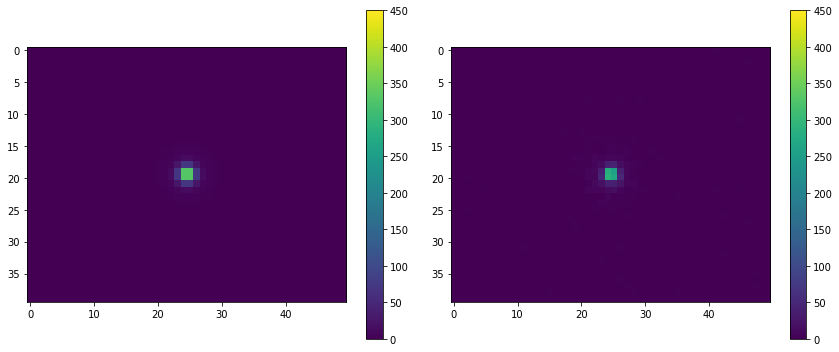

In [628]:
pred_counts=test_map.psf_convolve()
fig=plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
plt.imshow(pred_counts[0],vmin=0,vmax=450)
plt.colorbar()

ax=plt.subplot(1,2,2)
plt.imshow(counts[0],vmin=0,vmax=450)
plt.colorbar()

plt.tight_layout()

# sensitivity

In [641]:
# Spatial model
skydir=(0,0)
width=(4,5)
binsz=0.1
test_model=GaussianSpatialModel(3e-2,'deg',skydir,width,binsz)

# Spectrum model
energy_axes=PowerLawSpctralModel(3e-9,-1,10,name='Energy',unit='TeV')
energy_axes.parameters['Eref'].frozen=True
energy_axes.make_edges(width=(np.log10(0.01),np.log10(2)),num=6)

test_map=MapModel(geom=test_model,
                  axes=energy_axes,
                  exposure=exposure,
                  background=background,
                  psf_kernel=psf_kernel)
print(test_map.parameters)
origin_free_values=[3e-2,3e-9,-1]

Parameters
	    name        value           unit          frozen   
	------------ ------------ ---------------- ------------
	       sigma     3.00e-02              deg        False
	   prefactor     3.00e-09  1 / (cm2 GeV s)        False
	       index    -1.00e+00                         False
	        Eref     1.00e+01              GeV         True



In [692]:
def bin_fit(counts,map_model,idx_bin,x0,method='nelder-mead',disp=True,xatol=1e-5):
    def fun(x):
        map_model.parameters.set_parameters(map_model.parameters.free_names,x)
        return -np.sum(map_model.likelihood(counts),axis=(1,2))[idx_bin]

    res = minimize(fun, x0, method=method, options={'xatol': xatol, 'disp': disp})
    #map_model.parameters.set_parameters(map_model.parameters.free_names,res.x)
    return res

def all_bin_fit(counts,map_model,x0,method='mead',disp=False,xatol=1e-5):
    res_xs=[]
    for idx_bin in range(len(counts)):
        res=bin_fit(counts,test_map,idx_bin,fit_parameters.x,disp=disp,xatol=xatol)
        res_xs.append(res.x)
        if disp:
            print(f'{idx_bin} : {res.x}')
    return res_xs

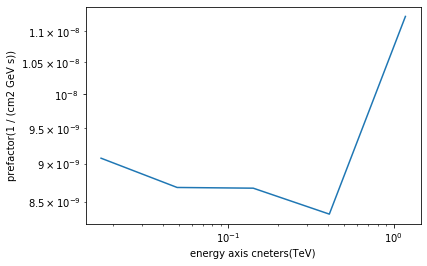

In [719]:
res_xs=all_bin_fit(counts,test_map,origin_free_values,method='mead',xatol=1e-6)

res_xs=np.asarray(res_xs)
plt.plot(test_map.axes.centers,res_xs[:,1])
plt.loglog()
plt.ylabel(f'prefactor({test_map.axes.prefactor.unit})')
_=plt.xlabel(f'energy axis cneters({test_map.axes.centers.unit})')

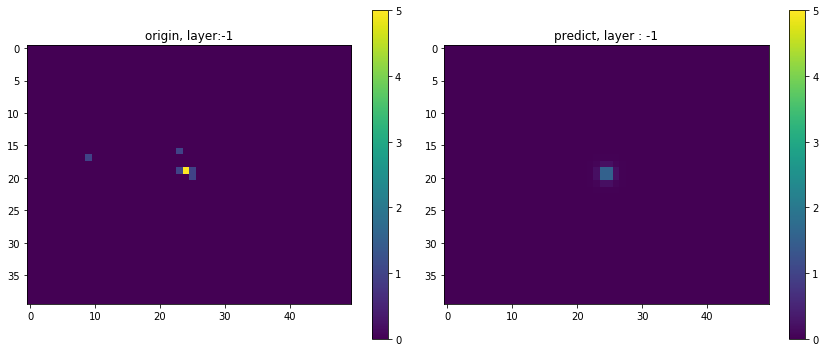

In [726]:
idx_layers=-1
pred_counts=test_map.psf_convolve()
vmax=counts[idx_layers].max()

fig=plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
plt.imshow(counts[idx_layers],vmin=0,vmax=vmax)
plt.colorbar()
plt.title('origin, layer:%i'%idx_layers)

ax=plt.subplot(1,2,2)
plt.imshow(pred_counts[idx_layers],vmin=0,vmax=vmax)
plt.colorbar()
plt.title('predict, layer : %i'%idx_layers)

plt.tight_layout()